# Finding Average SEP duration from Onset to Peak

name: 112, group:      Unnamed: 0    Julian Day  Year  DayOfYear  Intensity  %Rate/day  Index  \
448         448  2.455423e+06  2010  226.43403    0.12371     0.0000      1   
449         449  2.455423e+06  2010  226.50000   10.05800    95.4760      2   
450         450  2.455423e+06  2010  226.53819   14.60800    11.6040      3   
451         451  2.455423e+06  2010  226.62500    6.19230    -5.1731      4   

               datetime  
448 2010-08-14 10:25:00  
449 2010-08-14 12:00:00  
450 2010-08-14 12:54:00  
451 2010-08-14 15:00:00  
start time: 2010-08-14 10:25:00, peak_time: 2010-08-14 12:54:00
name: 113, group:      Unnamed: 0    Julian Day  Year  DayOfYear  Intensity  %Rate/day  Index  \
452         452  2.455628e+06  2011   66.90278    0.15431     0.0000      1   
453         453  2.455629e+06  2011   67.04861   11.26300    28.6080      2   
454         454  2.455629e+06  2011   67.34028   50.14600     5.0381      3   
455         455  2.455631e+06  2011   69.59722    6.80720 

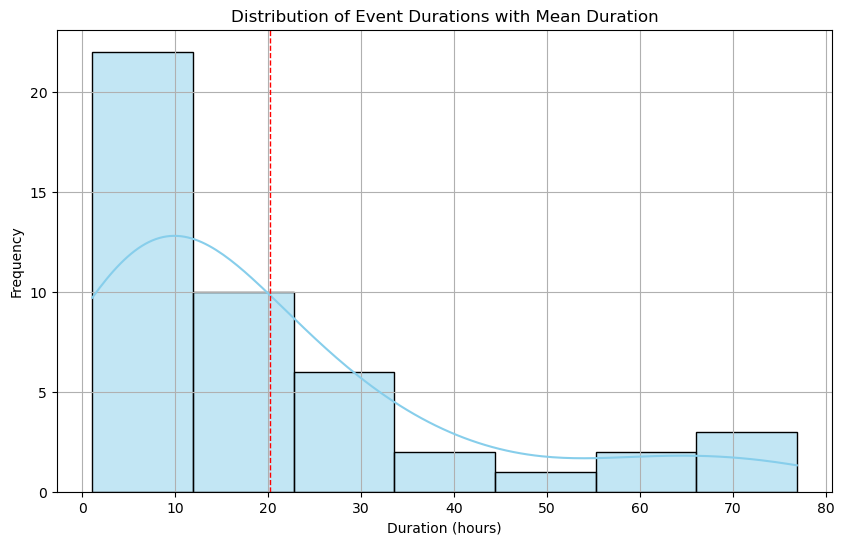

average sep duration: 0 days 20:13:56.086956521, number of seps:46


In [8]:
from dataload.calc_cme_history import calculate_average_duration
import pandas as pd

file_path = "D:/College/Fall2023/new_data/curr_pf10th10_original.csv"
df = pd.read_csv(file_path)

avg_sep_duration, num_seps = calculate_average_duration(df, start_year=2010, end_year=2017, debug=True)

# print the duration
print(f"average sep duration: {avg_sep_duration}, number of seps:{num_seps}")

# Building the dataset

steps involved in building the dataset. 

identify 46 SEPs and create 46 csv files for each SEP from pf10 file
each csv will have target time, feature time starting from the 

In [1]:
output_dir = "D:/College/Fall2023/electron_cme_data_12h"
sep_file_path = "D:/College/Fall2023/new_data/curr_pf10th10_original.csv"
cme_file_path = "D:/College/Fall2023/new_data/SEP10MeV_Features.csv"
flux_data_path = 'D:/College/Fall2023/new_data/ephin5m.dat'

In [2]:
import pandas as pd

# Load the dataset
file_path_ds1 = sep_file_path
df_ds1 = pd.read_csv(file_path_ds1)

# Display the first few rows to understand its structure
df_ds1.head()


,Unnamed: 0,Julian Day,Year,DayOfYear,Intensity,%Rate/day,Index,datetime
0,0,2.450011e+06,1995,293.26389,0.11119,0.0000,1,1995-10-20 06:20:00
1,1,2.450011e+06,1995,293.34375,10.93500,70.0420,2,1995-10-20 08:15:00
2,2,2.450011e+06,1995,293.51042,65.14900,11.1010,3,1995-10-20 12:15:00
3,3,2.450012e+06,1995,294.10417,6.93270,-4.1139,4,1995-10-21 02:30:00
4,4,2.450757e+06,1997,308.25347,0.16920,0.0000,1,1997-11-04 06:04:00


In [3]:
def find_sep_times(df, start_year=None, end_year=None):
    """
    Finds the onset time and peak time of each SEP event within a specified start and end year.

    Args:
        df (pd.DataFrame): DataFrame containing the SEP event data.
        start_year (int, optional): The start year for filtering events. Defaults to None.
        end_year (int, optional): The end year for filtering events. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame with columns ['Event', 'Onset Time', 'Peak Time']
    """
    # Convert datetime column to datetime objects
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Filter by year if specified
    if start_year:
        df = df[df['Year'] >= start_year]
    if end_year:
        df = df[df['Year'] <= end_year]

    # Initialize a list to store the event data
    events = []

    # Iterate over the groups (each group should represent an SEP event)
    for event_num, group in enumerate(df.groupby(df.index // 4)):
        group_data = group[1]
        onset_time = group_data[group_data['Index'] == 1]['datetime'].iloc[0]
        peak_time = group_data[group_data['Index'] == 3]['datetime'].iloc[0]
        events.append({'Event': event_num + 1, 'Onset Time': onset_time, 'Peak Time': peak_time})

    # Convert the list to a DataFrame
    sep_times = pd.DataFrame(events)

    return sep_times


In [4]:
# Applying the function to the dataset
sep_times_df = find_sep_times(df_ds1, start_year=2010, end_year=2017)

print(len(sep_times_df))

46


In [13]:
from typing import Dict, List, Optional, Tuple, Any
from datetime import timedelta, datetime
import pandas as pd
from dataload.electron_ts import load_flux_data
from dataload.calc_cme_history import cme_statistics_for_row

In [14]:
def process_group_data(
        group_data: pd.DataFrame, 
        start_idx: int = 1, 
        end_idx: int = 4, 
        hours_before: int = 12) -> Tuple[
    pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp, List[pd.Timestamp], List[pd.Timestamp]]:
    """
    Processes the SEP event group data to extract key timestamps and create target and feature time lists.

    Args:
        group_data (pd.DataFrame): Data frame containing SEP event group data.
        start_idx (int, optional): start index or onset time
        end_idx (int, optional): end index 
        hours_before (int, optional): Number of hours before the onset time to start the analysis.

    Returns:
        Tuple containing onset time, peak time, start time, target_tplus6 list, and features_t list.
    """
    onset_time = group_data[group_data['Index'] == start_idx]['datetime'].iloc[0]
    peak_time = group_data[group_data['Index'] == 3]['datetime'].iloc[0]
    end_time = group_data[group_data['Index'] == end_idx]['datetime'].iloc[0]
    start_time = onset_time - timedelta(hours=hours_before)

    target_tplus6 = []
    features_t = []
    current_time = start_time
    while current_time <= end_time:
        target_tplus6.append(current_time)
        features_t.append(current_time - timedelta(minutes=30))
        current_time += timedelta(minutes=5)

    # Check if the last timestep matches with the peak time, if not, add an additional timestep
    if target_tplus6[-1] != end_time:
        target_tplus6.append(current_time)
        features_t.append(current_time - timedelta(minutes=30))

    return onset_time, peak_time, start_time, end_time, target_tplus6, features_t


def initialize_event_dict(
        onset_time: pd.Timestamp,
        peak_time: pd.Timestamp,
        start_time: pd.Timestamp,
        end_time: pd.Timestamp,
        avg_sep_duration: timedelta) -> Dict[str, Any]:
    """
    Initializes the event dictionary with basic time data structure.

    Args:
        onset_time (pd.Timestamp): The onset time of the SEP event.
        peak_time (pd.Timestamp): The peak time of the SEP event.
        start_time (pd.Timestamp): The start time of the SEP event.
        end_time (pd.Timestamp): The end time of the SEP event.
        avg_sep_duration (timedelta): The average duration of an SEP event.

    Returns:
        Dict[str, Any]: A dictionary with the initialized time data for the event.
    """
    return {
        'onset_time': onset_time,
        'peak_time': peak_time,
        'start_time': start_time,
        'end_time': end_time,
        'avg_sep_duration': avg_sep_duration
    }


def create_flux_dict(timestamps: List[pd.Timestamp], ds3_flux: pd.DataFrame, flux_channel: str) -> Dict[
    pd.Timestamp, float]:
    """
    Creates a dictionary mapping each timestamp to its corresponding flux intensity from the specified channel.

    Args:
        timestamps (List[pd.Timestamp]): List of timestamps to map to flux intensities.
        ds3_flux (pd.DataFrame): DataFrame containing the flux data.
        flux_channel (str): The flux channel to use for intensity values.

    Returns:
        Dict[pd.Timestamp, float]: A dictionary mapping timestamps to flux intensities.
    """
    flux_dict = {}
    for time in timestamps:
        closest_time = ds3_flux.index.get_loc(time, method='nearest')
        flux_intensity = ds3_flux.loc[ds3_flux.index[closest_time], flux_channel]
        flux_dict[time] = flux_intensity
    return flux_dict


def process_cme_data(event_dict: Dict[str, Any], ds2: pd.DataFrame, features_t: List[pd.Timestamp],
                     cme_offset: timedelta, avg_sep_duration: timedelta) -> None:
    """
    Processes CME data and updates the event dictionary with detailed CME attributes.

    Args:
        event_dict (Dict[str, Any]): The event dictionary to update with CME data.
        ds2 (pd.DataFrame): DataFrame containing CME data with various attributes.
        features_t (List[pd.Timestamp]): List of feature timestamps.
        cme_offset (timedelta): Time offset for CME events.
        avg_sep_duration (timedelta): Average duration of an SEP event.
    """
    # Define the CME attributes to extract
    cme_attributes = ['CME_DONKI_latitude', 'CME_DONKI_longitude', 'CME_DONKI_speed',
                      'CME_CDAW_MPA', 'CME_CDAW_LinearSpeed', 'VlogV', 'DONKI_half_width',
                      'Accelaration', '2nd_order_speed_final', '2nd_order_speed_20R',
                      'CPA', 'Halo', 'Type2_Viz_Area', 'solar_wind_speed', 'diffusive_shock',
                      'half_richardson_value']

    cmes = {time: 0 for time in features_t}  # Default value is 0 for each timestamp
    for cme_time in ds2['CME_DONKI_time']:
        if features_t[0] <= cme_time <= features_t[-1]:  # Check if CME is within the event time window
            cme_start_index = next((i for i, time in enumerate(features_t) if time >= cme_time + cme_offset), None)
            if cme_start_index is not None:
                cme_data = ds2[ds2['CME_DONKI_time'] == cme_time].iloc[0]
                cme_info = {attr: cme_data[attr] for attr in cme_attributes}
                cme_info['cme_donki_time'] = cme_time

                for i in range(cme_start_index,
                               min(cme_start_index + avg_sep_duration // timedelta(minutes=5), len(features_t))):
                    cmes[features_t[i]] = cme_info

    event_dict['cmes'] = cmes


def validate_list_lengths(event_dict: Dict[str, Any], event_num: int) -> None:
    """
    Validates if all list-type values in the event dictionary have the same length and prints an appropriate message.

    Args:
        event_dict (Dict[str, Any]): The event dictionary to validate.
        event_num (int): The number of the current event being processed.
    """
    list_lengths = [len(v) for k, v in event_dict.items() if
                    isinstance(v, list) or isinstance(v, dict)]  # Check for lists and dictionaries
    if not list_lengths:
        print(f"No lists or dictionaries found in event {event_num}.")
        return

    common_length = list_lengths[0]
    if all(length == common_length for length in list_lengths):
        print(f"All lists in event {event_num} have a common length of {common_length}.")
    else:
        print(f"Error: Lists in event {event_num} do not have a common length.")


def get_daily_sunspot_numbers(ds2: pd.DataFrame, features_t: List[pd.Timestamp]) -> List[Optional[int]]:
    """
    Retrieves the daily sunspot numbers for each timestamp in features_t from ds2.

    Args:
        ds2 (pd.DataFrame): DataFrame containing CME and sunspot data.
        features_t (List[pd.Timestamp]): List of timestamps for which to retrieve daily sunspot numbers.

    Returns:
        List[Optional[int]]: List of daily sunspot numbers corresponding to each timestamp in features_t.
    """
    # Convert CME_DONKI_time to just dates in ds2 for easier matching
    ds2['Date'] = ds2['CME_DONKI_time'].dt.date

    daily_sunspot_nums = []
    for time in features_t:
        matched_row = ds2[ds2['Date'] == time.date()]
        sunspot_number = matched_row['daily_sunspots'].iloc[0] if not matched_row.empty else None
        daily_sunspot_nums.append(sunspot_number)

    return daily_sunspot_nums


def save_event_data_to_csv(event_id: int, event_dict: Dict[str, Any], output_path: str) -> None:
    """
    Saves the data for a specific SEP event to a CSV file.

    This function creates a DataFrame from the event data dictionary and saves it as a CSV file in the specified output path.
    The CSV file includes various data points for each timestamp in the event.

    Args:
        event_id (int): The unique identifier of the SEP event.
        event_dict (Dict[str, Any]): A dictionary containing the detailed time data for the SEP event.
        output_path (str): The directory path where the CSV file will be saved.

    Returns:
        None
    """
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Calculate Target Timestamps (assuming a fixed offset, e.g., 30 minutes)
    target_timestamps = [ts + timedelta(minutes=30) for ts in event_dict['features_t']]

    # Prepare data for DataFrame
    df_data = {
        'Event ID': [event_id] * len(event_dict['features_t']),
        'Timestamp': event_dict['features_t'],
        'Target Timestamp': target_timestamps,
        'Proton Intensity': list(event_dict['target_tplus6'].values()),  # Grab only values
    }

    # Add tminus... and t columns
    for i in range(24, 0, -1):
        tminus_key = f'tminus{i}'
        df_data[tminus_key] = list(event_dict[tminus_key].values())

    # Add 't' column
    df_data['t'] = list(event_dict['t'].values())

    # Max Electron Intensity and other columns
    df_data['Max Electron Intensity'] = event_dict['max_electron_intensity']
    df_data['Sunspot Number'] = event_dict['daily_sunspot_num']

    # Flatten CME Attributes
    cme_keys = ['cme_donki_time', 'CME_DONKI_latitude', 'CME_DONKI_longitude', 'CME_DONKI_speed',
                'CME_CDAW_MPA', 'CME_CDAW_LinearSpeed', 'VlogV', 'DONKI_half_width',
                'Accelaration', '2nd_order_speed_final', '2nd_order_speed_20R',
                'CPA', 'Halo', 'Type2_Viz_Area', 'solar_wind_speed', 'diffusive_shock',
                'half_richardson_value']
    for key in cme_keys:
        cme_attribute_list = []
        for ts in event_dict['features_t']:
            if isinstance(event_dict['cmes'][ts], dict):
                cme_attribute_list.append(event_dict['cmes'][ts].get(key, 0))
            else:
                cme_attribute_list.append(0)
        df_data[key] = cme_attribute_list

    # Add CME Counts and Speeds
    df_data['CMEs Past Month'] = event_dict['CMEs_in_past_month']
    df_data['CMEs Past 9 Hours'] = event_dict['CMEs_in_past_9hours']
    df_data['CMEs Speed > 1000'] = event_dict['CMEs_with_speed_over_1000_in_past_9hours']
    df_data['Max CME Speed'] = event_dict['max_CME_speed_in_past_day']

    # print('df_data: ')
    # print(df_data)

    # Create DataFrame
    df = pd.DataFrame(df_data)

    # Save the DataFrame to a CSV file
    filename = os.path.join(output_path, f"sep_event_{event_id}.csv")
    df.to_csv(filename, index=False)


def dump_event(event_id: int, event_dict: Dict[str, Any], output_path: str) -> None:
    """
    Dumps the SEP event data dictionary into a text file.

    Args:
        event_id (int): The unique identifier of the SEP event.
        event_dict (Dict[str, Any]): A dictionary containing the detailed time data for the SEP event.
        output_path (str): The directory path where the text file will be saved.

    Returns:
        None
    """
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Construct the filename for the text file
    filename = os.path.join(output_path, f"sep_event_{event_id}.txt")

    # Dump the event data into a text file
    with open(filename, 'w') as file:
        file.write(str(event_dict))



In [15]:
def generate_event_time_data(sep_path: str, cme_path: str, flux_path: str,
                             start_year: Optional[int] = None,
                             end_year: Optional[int] = None,
                             cme_offset: timedelta = timedelta(minutes=30),
                             avg_sep_duration: timedelta = timedelta(days=0, hours=20, minutes=13, seconds=56,
                                                                     microseconds=86956),
                             proton_flux_channel: str = 'Proton_Flux_16.40MeV',
                             electron_flux_channel: str = 'Electron_Flux_0.5MeV',
                             output_path: str = "D:/College/Fall2023/electron_cme_data") -> Dict[
    int, Dict[str, Dict[pd.Timestamp, float]]]:
    """
    Generates detailed time data for each SEP event in ds1, including CME times from ds2, proton flux, and electron flux data.

    Args:
        sep_path (str): Path to the SEP events data file.
        cme_path (str): Path to the CME features data file.
        flux_path (str): Path to the flux data file.
        start_year (Optional[int]): Start year for filtering SEP events. Defaults to None.
        end_year (Optional[int]): End year for filtering SEP events. Defaults to None.
        cme_offset (timedelta): Time offset for CME events.
        avg_sep_duration (timedelta): Average duration of an SEP event.
        proton_flux_channel (str): Proton flux channel to be used for target_tplus6 data.
        electron_flux_channel (str): Electron flux channel to be used for tminus data.
        output_path (str): Path for saving the output data.

    Returns:
        Dict[int, Dict[str, Dict[pd.Timestamp, float]]]: A dictionary with detailed time data for each SEP event.
    """
    # Load data
    ds1 = pd.read_csv(sep_path)  # SEP events
    ds2 = pd.read_csv(cme_path)  # CME features
    ds3_flux = load_flux_data(flux_path)  # Flux data

    # Convert datetime columns to datetime objects and filter ds1 by year
    ds1['datetime'] = pd.to_datetime(ds1['datetime'])
    ds2['CME_DONKI_time'] = pd.to_datetime(ds2['CME_DONKI_time'], format='%m/%d/%Y %H:%M')
    if start_year: ds1 = ds1[ds1['Year'] >= start_year]
    if end_year: ds1 = ds1[ds1['Year'] <= end_year]

    event_time_data = {}

    for event_num, group in enumerate(ds1.groupby(ds1.index // 4)):
        # if event_num > 7: break  # for debugging purposes
        group_data = group[1]
        onset_time, peak_time, start_time, end_time, target_tplus6, features_t = process_group_data(group_data)
        event_dict = initialize_event_dict(onset_time, peak_time, start_time, end_time, avg_sep_duration)

        # Make sure to add 'features_t' to the event_dict
        event_dict['features_t'] = features_t

        # Create target_tplus6 with proton intensities
        event_dict['target_tplus6'] = create_flux_dict(target_tplus6, ds3_flux, proton_flux_channel)

        # Process CME data and add cmes to the event dictionary
        process_cme_data(event_dict, ds2, features_t, cme_offset, avg_sep_duration)

        # Create tminus... dictionaries with electron intensities
        for i in range(24, 0, -1):
            key_name = f'tminus{i}'
            event_dict[key_name] = create_flux_dict([time - timedelta(minutes=i * 5) for time in features_t],
                                                    ds3_flux,
                                                    electron_flux_channel)

        # Set 't' key as features_t with electron intensities
        event_dict['t'] = create_flux_dict(features_t, ds3_flux, electron_flux_channel)

        # Calculate max electron intensity for each timestamp
        max_electron_intensities = []
        for time in features_t:
            # Gather intensities from all tminus... and t dictionaries for this timestamp
            intensities_at_time = [event_dict.get(f'tminus{24 - i}', {}).get(time, 0) for i in range(24)]
            intensities_at_time.append(event_dict.get('t', {}).get(time, 0))  # Add intensity from 't'

            # Determine the maximum intensity at this timestamp
            max_intensity = max(intensities_at_time)
            max_electron_intensities.append(max_intensity)

        # Add max_electron_intensity to the event dictionary
        event_dict['max_electron_intensity'] = max_electron_intensities

        # Initialize lists for the new keys
        past_month_counts = []
        past_9hr_counts = []
        past_9hr_speed_counts = []
        past_day_max_speeds = []

        # Calculate CME statistics for each timestamp in features_t
        for time in features_t:
            month_count, _9hr_count, _9hr_speed_count, day_max_speed = cme_statistics_for_row(ds2, time)
            past_month_counts.append(month_count)
            past_9hr_counts.append(_9hr_count)
            past_9hr_speed_counts.append(_9hr_speed_count)
            past_day_max_speeds.append(day_max_speed)

        # Add new keys to the event dictionary
        event_dict['CMEs_in_past_month'] = past_month_counts
        event_dict['CMEs_in_past_9hours'] = past_9hr_counts
        event_dict['CMEs_with_speed_over_1000_in_past_9hours'] = past_9hr_speed_counts
        event_dict['max_CME_speed_in_past_day'] = past_day_max_speeds

        # Get daily sunspot numbers for each timestamp in features_t
        daily_sunspot_nums = get_daily_sunspot_numbers(ds2, features_t)

        # Add daily_sunspot_num to the event dictionary
        event_dict['daily_sunspot_num'] = daily_sunspot_nums

        # Validate list lengths and add nticks
        validate_list_lengths(event_dict, event_num + 1)
        event_dict['nticks'] = len(event_dict['features_t'])

        event_time_data[event_num + 1] = event_dict
        # Save event data to CSV
        save_event_data_to_csv(event_num + 1, event_dict, output_path)
        # dump_event(event_num + 1, event_dict, output_path)

    return event_time_data

In [16]:
output_dir = "D:/College/Fall2023/electron_cme_data_12h"
sep_file_path = "D:/College/Fall2023/new_data/curr_pf10th10_original.csv"
cme_file_path = "D:/College/Fall2023/new_data/SEP10MeV_Features.csv"
flux_file_path = 'D:/College/Fall2023/new_data/ephin5m.dat'

In [17]:
# Applying the function to the dataset
event_time_data5 = generate_event_time_data(
    sep_file_path,
    cme_file_path,
    flux_file_path,
    start_year=2010, end_year=2017)

All lists in event 1 have a common length of 200.
All lists in event 2 have a common length of 921.
All lists in event 3 have a common length of 412.
All lists in event 4 have a common length of 603.
All lists in event 5 have a common length of 760.
All lists in event 6 have a common length of 301.
All lists in event 7 have a common length of 1217.
All lists in event 8 have a common length of 884.
All lists in event 9 have a common length of 683.
All lists in event 10 have a common length of 1431.
All lists in event 11 have a common length of 1216.
All lists in event 12 have a common length of 1457.
All lists in event 13 have a common length of 1221.
All lists in event 14 have a common length of 595.
All lists in event 15 have a common length of 638.
All lists in event 16 have a common length of 320.
All lists in event 17 have a common length of 312.
All lists in event 18 have a common length of 418.
All lists in event 19 have a common length of 378.
All lists in event 20 have a common

In [18]:
# Example: Display the detailed time data for the first event
first_event_data5 = event_time_data5.get(6, {})
first_event_data5

{'onset_time': Timestamp('2011-08-09 08:10:00'),
 'peak_time': Timestamp('2011-08-09 09:15:00'),
 'start_time': Timestamp('2011-08-08 20:10:00'),
 'end_time': Timestamp('2011-08-09 21:09:00'),
 'avg_sep_duration': datetime.timedelta(seconds=72836, microseconds=86956),
 'features_t': [Timestamp('2011-08-08 19:40:00'),
  Timestamp('2011-08-08 19:45:00'),
  Timestamp('2011-08-08 19:50:00'),
  Timestamp('2011-08-08 19:55:00'),
  Timestamp('2011-08-08 20:00:00'),
  Timestamp('2011-08-08 20:05:00'),
  Timestamp('2011-08-08 20:10:00'),
  Timestamp('2011-08-08 20:15:00'),
  Timestamp('2011-08-08 20:20:00'),
  Timestamp('2011-08-08 20:25:00'),
  Timestamp('2011-08-08 20:30:00'),
  Timestamp('2011-08-08 20:35:00'),
  Timestamp('2011-08-08 20:40:00'),
  Timestamp('2011-08-08 20:45:00'),
  Timestamp('2011-08-08 20:50:00'),
  Timestamp('2011-08-08 20:55:00'),
  Timestamp('2011-08-08 21:00:00'),
  Timestamp('2011-08-08 21:05:00'),
  Timestamp('2011-08-08 21:10:00'),
  Timestamp('2011-08-08 21:15:00'

In [28]:
import numpy as np
import pandas as pd


def stratified_sampling(df, train_ratio=2 / 3, subtrain_ratio=3 / 4):
    # Sort the DataFrame by intensity
    df_sorted = df.sort_values(by='intensity')

    # Calculate the number of samples for each set
    total_samples = len(df_sorted)
    num_train = int(total_samples * train_ratio)
    num_test = total_samples - num_train
    num_subtrain = int(num_train * subtrain_ratio)
    num_validation = num_train - num_subtrain

    # Initialize lists to store indices
    train_indices = []
    test_indices = []
    subtrain_indices = []
    validation_indices = []

    # Distribute indices for training and testing
    for i in range(0, total_samples, 3):
        group = df_sorted.index[i:i + 3].tolist()
        train_indices.extend(group[:2])  # First 2 of every 3 for training
        test_indices.extend(group[2:])  # Last of every 3 for testing

    # Distribute indices for subtraining and validation from the training set
    for i in range(0, num_train, 4):
        group = train_indices[i:i + 4]
        subtrain_indices.extend(group[:3])  # First 3 of every 4 for subtraining
        validation_indices.extend(group[3:])  # Last of every 4 for validation

    # Shuffle the indices in each group
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    np.random.shuffle(subtrain_indices)
    np.random.shuffle(validation_indices)

    # Return the distribution of indices
    return {
        'train': train_indices,
        'test': test_indices,
        'subtrain': subtrain_indices,
        'validation': validation_indices
    }

In [29]:
# Applying the function to the DataFrame
file_path = 'D:/College/Fall2023/new_data/seps_to_stratify.csv'
df = pd.read_csv(file_path)
index_distribution = stratified_sampling(df)

# Output the distribution of indices for verification
index_distribution



{'train': [22,
  21,
  37,
  9,
  36,
  27,
  16,
  17,
  12,
  19,
  3,
  30,
  31,
  41,
  1,
  25,
  44,
  33,
  20,
  0,
  13,
  32,
  4,
  6,
  14,
  42,
  2,
  5,
  38,
  39,
  24],
 'test': [28, 35, 23, 45, 10, 7, 43, 18, 11, 29, 34, 26, 8, 40, 15],
 'subtrain': [3,
  41,
  6,
  27,
  16,
  22,
  20,
  4,
  14,
  17,
  0,
  36,
  12,
  37,
  25,
  13,
  32,
  9,
  1,
  33,
  38,
  24,
  39,
  5],
 'validation': [2, 44, 31, 19, 42, 30, 21]}

In [30]:
import csv

save_path = 'D:/College/Fall2023/new_data/index_distr.csv'
with open(save_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Group', 'Indices'])
    for key, indices in index_distribution.items():
        writer.writerow([key, ' '.join(map(str, indices))])


In [31]:
import os
import shutil


def organize_files(index_distribution, source_dir, base_dir):
    # Define the target directories
    target_dirs = {
        'train': os.path.join(base_dir, 'training'),
        'subtrain': os.path.join(base_dir, 'subtraining'),
        'validation': os.path.join(base_dir, 'validation'),
        'test': os.path.join(base_dir, 'testing')
    }

    # Create target directories if they don't exist
    for dir_path in target_dirs.values():
        os.makedirs(dir_path, exist_ok=True)

    # Copy files to their respective directories
    for group, indices in index_distribution.items():
        for index in indices:
            file_name = f'sep_event_{index + 1}_filled_ie.csv'  # Adjusting index to match file naming
            src_path = os.path.join(source_dir, file_name)
            dst_path = os.path.join(target_dirs[group], file_name)
            try:
                shutil.copy(src_path, dst_path)
            except FileNotFoundError:
                print(f"File not found: {file_name}, skipping...")

In [32]:
input_sep_dir = "D:/College/Fall2023/electron_cme_data_filled_12h"
output_sep_dir = "D:/College/Fall2023/electron_cme_data_split_12h"
organize_files(index_distribution, input_sep_dir, output_sep_dir)


# Filling in Missing Sunspot Numbers

In [19]:
import pandas as pd
from typing import Optional


def fill_missing_sunspot_numbers(sep_event_file_path: str, sn_data_file_path: str, output_dir: str) -> None:
    """
    Reads an SEP event CSV file and a Sunspot Number (SN) CSV file.
    It fills in missing Sunspot Numbers in the SEP event file based on the SN data file
    by matching the year, month, and day, then writes the updated SEP event file to the specified output directory.
    
    :param sep_event_file_path: Path to the SEP event CSV file.
    :param sn_data_file_path: Path to the SN data CSV file.
    :param output_dir: Directory to save the updated SEP event CSV file.
    """
    # Load the SEP event data
    sep_data = pd.read_csv(sep_event_file_path)

    # Load the Sunspot Number data
    sn_data = pd.read_csv(sn_data_file_path, delimiter=';', header=None,
                          names=['Year', 'Month', 'Day', 'Decimal Year', 'Sunspot Number',
                                 'Standard Error', 'Observations', 'Definitive/Provisional'])

    # Convert Year, Month, Day to a single datetime column in SN data for easier comparison
    sn_data['Date'] = pd.to_datetime(sn_data[['Year', 'Month', 'Day']])

    # Drop unused columns
    sn_data = sn_data.drop(columns=['Decimal Year', 'Standard Error', 'Observations', 'Definitive/Provisional'])

    # Create a dictionary from the SN data for quick lookup
    sn_dict = pd.Series(sn_data['Sunspot Number'].values, index=sn_data['Date']).to_dict()

    # Define a function to safely parse the date from the timestamp
    def safe_parse_date(timestamp_str: str) -> pd.Timestamp:
        try:
            return pd.to_datetime(timestamp_str.split(' ')[0])  # Only taking the date part
        except ValueError as e:
            raise ValueError(f"Error parsing date from timestamp '{timestamp_str}': {e}")

    # Apply the function to fill in missing Sunspot Numbers
    for i, row in sep_data.iterrows():
        if pd.isnull(row['Sunspot Number']):  # Check if Sunspot Number is NaN
            # print found NaN at row in file 
            print(f"Found NaN at row {i} in file {sep_event_file_path}")
            date = safe_parse_date(row['Timestamp'])  # Parse the date from Timestamp
            sep_data.at[i, 'Sunspot Number'] = sn_dict.get(date, pd.NA)  # Get the Sunspot Number from sn_dict

    # Generate the output file path using os.path.join and os.path.splitext for cross-platform compatibility
    base_filename = os.path.splitext(os.path.basename(sep_event_file_path))[0]
    output_file_path = os.path.join(output_dir, f"{base_filename}_filled.csv")

    sep_data.to_csv(output_file_path, index=False)
    return output_file_path

In [9]:
# # File paths
# sep_event_file_path = 'D:/College/Fall2023/electron_cme_data/sep_event_7.csv'
# sn_d_tot_file_path = 'D:/College/Fall2023/new_data/SN_d_tot_V2.0.csv'
# output_dir = 'D:/College/Fall2023/electron_cme_data'
# 
# # fill_missing_sunspot_numbers(sep_event_file_path, sn_d_tot_file_path, output_dir)


In [20]:
# loop through all the files in directory
import os

sep_event_dir = 'D:/College/Fall2023/electron_cme_data'
destin_dir = 'D:/College/Fall2023/electron_cme_data_filled_12h'
sn_d_tot_file_path = 'D:/College/Fall2023/new_data/SN_d_tot_V2.0.csv'

# Ensure the destination directory exists
if not os.path.exists(destin_dir):
    os.makedirs(destin_dir)

for filename in os.listdir(sep_event_dir):
    if filename.endswith(".csv"):
        sep_event_file_path = os.path.join(sep_event_dir, filename)
        fill_missing_sunspot_numbers(sep_event_file_path, sn_d_tot_file_path, destin_dir)

    else:
        continue

Found NaN at row 0 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 1 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 2 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 3 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 4 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 5 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 6 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 7 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 8 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 9 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 10 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 11 in file D:/College/Fall2023/electron_cme_data\sep_event_1.csv
Found NaN at row 12 in fil

# fixing the missing intensities

In [21]:
import pandas as pd
import numpy as np
from typing import List


def interpolate_and_extrapolate(data: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Interpolates and extrapolates missing values in specified columns of a dataframe. 
    Missing values surrounded by available data are interpolated linearly. 
    Missing values at the beginning or end of the data are extrapolated based on the nearest available values. 
    If no data is available for interpolation/extrapolation, a large negative value is inserted.
    
    Parameters:
    data (pd.DataFrame): The input dataframe with missing values.
    columns (List[str]): List of column names to apply interpolation and extrapolation.
    
    Returns:
    pd.DataFrame: The dataframe with missing values handled.
    """

    for column in columns:
        # Check if the column has any non-missing values for processing
        if data[column].notna().any():
            # Interpolate missing values
            data[column] = data[column].interpolate(method='linear', limit_direction='both')

            # Extrapolate missing values at the beginning
            if pd.isna(data[column].iloc[0]):
                data[column].iloc[0] = data[column].loc[data[column].first_valid_index()]

            # Extrapolate missing values at the end
            if pd.isna(data[column].iloc[-1]):
                data[column].iloc[-1] = data[column].loc[data[column].last_valid_index()]
        else:
            # If no data available, fill with a large negative value
            data[column].fillna(-9999, inplace=True)

    return data

In [24]:
# file_path1 = 'D:/College/Fall2023/electron_cme_data_filled/sep_event_7_filled.csv'
# file_path2 = 'D:/College/Fall2023/electron_cme_data_filled/sep_event_20_filled.csv'
# # output path
# output_path1 = 'D:/College/Fall2023/electron_cme_data_filled/sep_event_7_filled_ie.csv'
# output_path2 = 'D:/College/Fall2023/electron_cme_data_filled/sep_event_20_filled_ie.csv'
# # Load your data
# df = pd.read_csv(file_path2)
# 
# # Specify the columns you wish to process, e.g., Proton Intensity and electron intensities columns
# columns_to_process = ['Proton Intensity', 'tminus24', 'tminus23', 'tminus22',
#                       'tminus21', 'tminus20', 'tminus19', 'tminus18', 'tminus17', 'tminus16',
#                       'tminus15', 'tminus14', 'tminus13', 'tminus12', 'tminus11', 'tminus10',
#                       'tminus9', 'tminus8', 'tminus7', 'tminus6', 'tminus5', 'tminus4',
#                       'tminus3', 'tminus2', 'tminus1', 't']  # include all relevant columns
# 
# # Apply the function to your data
# df_processed = interpolate_and_extrapolate(df, columns_to_process)
# 
# # Save the processed DataFrame to a new CSV file
# df_processed.to_csv(output_path2, index=False)


In [22]:
# apply to the directory the interpolation and extrapolation
import os


def process_files_in_directory(directory: str) -> None:
    """
    Process all CSV files in a given directory, interpolating and extrapolating missing values in specified columns.
    
    :param directory: The path to the directory containing the CSV files to be processed.
    """
    columns_to_process = [
        'Proton Intensity', 'tminus24', 'tminus23', 'tminus22', 'tminus21', 'tminus20',
        'tminus19', 'tminus18', 'tminus17', 'tminus16', 'tminus15', 'tminus14', 'tminus13',
        'tminus12', 'tminus11', 'tminus10', 'tminus9', 'tminus8', 'tminus7', 'tminus6',
        'tminus5', 'tminus4', 'tminus3', 'tminus2', 'tminus1', 't'
    ]  # include all relevant columns

    for filename in os.listdir(directory):
        if filename.endswith("_filled.csv"):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)

            # Apply the function to your data
            df_processed = interpolate_and_extrapolate(df, columns_to_process)

            # Generate the output file path
            output_file_path = os.path.join(directory, filename.replace('_filled.csv', '_filled_ie.csv'))

            # Save the processed DataFrame to a new CSV file
            df_processed.to_csv(output_file_path, index=False)
            print(f"Processed and saved: {output_file_path}")

In [23]:
# Example usage
directory_path = 'D:/College/Fall2023/electron_cme_data_filled_12h'
process_files_in_directory(directory_path)


Processed and saved: D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_10_filled_ie.csv
Processed and saved: D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_11_filled_ie.csv
Processed and saved: D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_12_filled_ie.csv
Processed and saved: D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_13_filled_ie.csv
Processed and saved: D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_14_filled_ie.csv
Processed and saved: D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_15_filled_ie.csv
Processed and saved: D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_16_filled_ie.csv
Processed and saved: D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_17_filled_ie.csv
Processed and saved: D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_18_filled_ie.csv
Processed and saved: D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_19_filled_ie.csv
Processed and saved: D:/Colleg

In [24]:
import pandas as pd


def update_max_electron_intensity_per_row(file_path: str) -> None:
    """
    Reads a SEP event CSV file, calculates the maximum electron intensity for each row,
    and updates the 'Max Electron Intensity' column with these values.

    :param file_path: Path to the SEP event CSV file.
    """
    # Load the data
    df = pd.read_csv(file_path)

    # Define the electron intensity columns
    electron_intensity_columns = [
        'tminus24', 'tminus23', 'tminus22', 'tminus21', 'tminus20',
        'tminus19', 'tminus18', 'tminus17', 'tminus16', 'tminus15',
        'tminus14', 'tminus13', 'tminus12', 'tminus11', 'tminus10',
        'tminus9', 'tminus8', 'tminus7', 'tminus6', 'tminus5',
        'tminus4', 'tminus3', 'tminus2', 'tminus1', 't'
    ]

    # Calculate max electron intensity for each row and update the 'Max Electron Intensity' column
    df['Max Electron Intensity'] = df[electron_intensity_columns].max(axis=1)

    # Save the updated DataFrame back to csv
    df.to_csv(file_path, index=False)
    print(f"Updated file saved to {file_path}")


In [ ]:
# # Example usage:
# file_path = 'D:/College/Fall2023/electron_cme_data_filled/sep_event_7_filled_ie.csv'
# 
# update_max_electron_intensity_per_row(file_path)


In [26]:
def update_max_intensity_in_directory(directory: str) -> None:
    """
    Processes all *_ie.csv files in a given directory, updating the 'Max Electron Intensity' column
    for each file with the maximum value of the electron intensity columns (tminus24 through t) row by row.

    :param directory: The path to the directory containing the CSV files to be processed.
    """
    # Define the electron intensity columns
    electron_intensity_columns = [
        'tminus24', 'tminus23', 'tminus22', 'tminus21', 'tminus20',
        'tminus19', 'tminus18', 'tminus17', 'tminus16', 'tminus15',
        'tminus14', 'tminus13', 'tminus12', 'tminus11', 'tminus10',
        'tminus9', 'tminus8', 'tminus7', 'tminus6', 'tminus5',
        'tminus4', 'tminus3', 'tminus2', 'tminus1', 't'
    ]

    # Loop through all files in the specified directory
    for filename in os.listdir(directory):
        if filename.endswith("_ie.csv"):  # Check if the file matches the pattern
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)

            # Update 'Max Electron Intensity' with the max of the electron intensities row by row
            df['Max Electron Intensity'] = df[electron_intensity_columns].max(axis=1)

            # Save the updated DataFrame back to csv
            df.to_csv(file_path, index=False)
            print(f"Updated file saved to {file_path}")

In [27]:
# Example usage:
directory = 'D:/College/Fall2023/electron_cme_data_filled_12h'
update_max_intensity_in_directory(directory)


Updated file saved to D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_10_filled_ie.csv
Updated file saved to D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_11_filled_ie.csv
Updated file saved to D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_12_filled_ie.csv
Updated file saved to D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_13_filled_ie.csv
Updated file saved to D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_14_filled_ie.csv
Updated file saved to D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_15_filled_ie.csv
Updated file saved to D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_16_filled_ie.csv
Updated file saved to D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_17_filled_ie.csv
Updated file saved to D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_18_filled_ie.csv
Updated file saved to D:/College/Fall2023/electron_cme_data_filled_12h\sep_event_19_filled_ie.csv
Updated file saved t